In [222]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics, linear_model, decomposition, cross_decomposition
from itertools import combinations
import numpy as np
import time 

In [236]:
hitters_dat = pd.read_csv('hitters.csv')
hitters_dat = hitters_dat.drop(hitters_dat.columns[0], axis=1)
hitters_dat = hitters_dat.dropna(axis=0)
hitters_dat['League'] = hitters_dat['League'].map({'N' : 1., 'A' : 0.})
hitters_dat['Division'] = hitters_dat['Division'].map({'W' : 1., 'E' : 0.})
hitters_dat['NewLeague'] = hitters_dat['NewLeague'].map({'N' : 1., 'A' : 0.})
#hitters_dat = (hitters_dat - hitters_dat.mean()) / hitters_dat.std()
hitters_dat.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,1.0,1.0,632,43,10,475.0,1.0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,0.0,1.0,880,82,14,480.0,0.0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1.0,0.0,200,11,3,500.0,1.0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,1.0,0.0,805,40,4,91.5,1.0
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0.0,1.0,282,421,25,750.0,0.0


In [1]:
# Best subset selection
# There are 2 ^ 19 ~= 5 * 10^5 possible subsets of all features.
# Trying them all takes ages.
# For 4 predictors there are (19 choose 1) + .. + (19 choose 4) ~= 5 * 10^3 possible models.

def n_choose_k(n, k):
    return int(np.math.factorial(n) / (np.math.factorial(n - k) * np.math.factorial(k)))

def best_subset(n_predictors, target_column, data):
    i = 1
    predictors = data.drop(target_column, axis=1).columns
    top_models = []
    while i <= n_predictors:
        tick = time.time()
        cmbs = list(combinations(predictors, i))
        formulae = ['Salary ~ ' + ' + '.join(s) for s in cmbs]
        models = [smf.ols(formula=f, data=data).fit() for f in formulae]
        top_model = sorted(models, key=lambda m: m.rsquared, reverse=True)[0]
        top_models.append(top_model)
        tock = time.time()
        print('{}/{} : {} combinations, {} seconds'.format(i, n_predictors, n_choose_k(n_predictors, i), tock-tick))
        i += 1
    return pd.DataFrame({'model' : top_models, 'n_predictors' : range(1, n_predictors + 1)})


In [238]:
# Select between models with different numbers of predictors using adjusted training metrics
best = best_subset(3, 'Salary', hitters_dat)
best['adj_R_sq'] = best['model'].map(lambda m: m.rsquared_adj)
best['bic'] = best['model'].map(lambda m: m.bic)
best['aic'] = best['model'].map(lambda m: m.aic)

1/3 : 3 combinations, 0.07082295417785645 seconds
2/3 : 3 combinations, 0.7477953433990479 seconds
3/3 : 1 combinations, 5.140793085098267 seconds


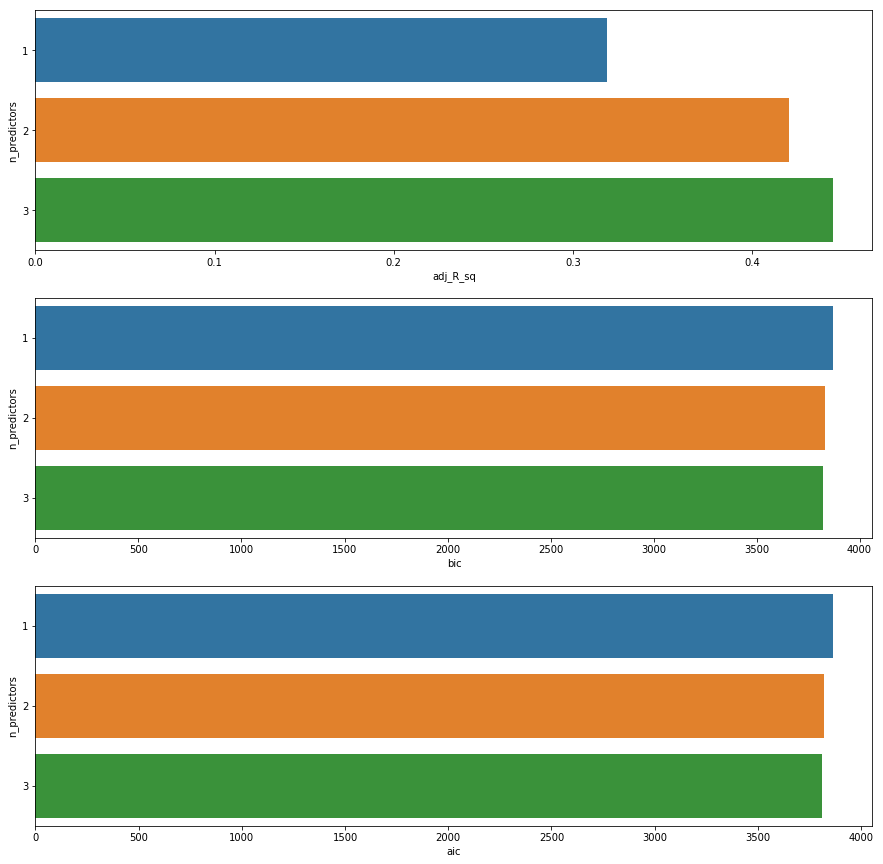

In [239]:
# Plot the error metrics
_, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15,15))
sns.barplot(y='n_predictors', x='adj_R_sq', data=best, ax=ax1, orient='h')
sns.barplot(y='n_predictors', x='bic', data=best, ax=ax2, orient='h')
sns.barplot(y='n_predictors', x='aic', data=best, ax=ax3, orient='h')

In [249]:
# Select between models with different numbers of predictors using the validation set approach
train, test = model_selection.train_test_split(hitters_dat, test_size=0.2)
best = best_subset(3, 'Salary', train)
best['MSE'] = best['model'].map(lambda m: metrics.mean_squared_error(test['Salary'], m.predict(test)))
best

1/3 : 3 combinations, 0.07045507431030273 seconds
2/3 : 3 combinations, 0.7818019390106201 seconds
3/3 : 1 combinations, 5.664794921875 seconds


,model,n_predictors,MSE
0,<statsmodels.regression.linear_model.Regressio...,1,199054.342456
1,<statsmodels.regression.linear_model.Regressio...,2,146475.652896
2,<statsmodels.regression.linear_model.Regressio...,3,140876.193344


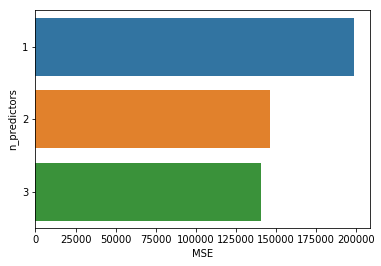

In [251]:
# Plot the error metric
sns.barplot(y='n_predictors', x='MSE', data=best, orient='h')

In [309]:
# Select between models with different numbers of predictors using cross validation
results = pd.DataFrame()
for train_idx, test_idx in model_selection.KFold(n_splits=10).split(hitters_dat):
    train = hitters_dat.iloc[train_idx]
    test = hitters_dat.iloc[test_idx]
    best = best_subset(3, 'Salary', train)
    mse = best['model'].map(lambda m: metrics.mean_squared_error(test['Salary'], m.predict(test)))
    results = results.append(mse, ignore_index=True)
    
best['MSE'] = results.mean()
best

1/3 : 3 combinations, 0.07561683654785156 seconds
2/3 : 3 combinations, 0.7820789813995361 seconds
3/3 : 1 combinations, 5.312049150466919 seconds
1/3 : 3 combinations, 0.06390810012817383 seconds
2/3 : 3 combinations, 0.7506320476531982 seconds
3/3 : 1 combinations, 5.409984111785889 seconds
1/3 : 3 combinations, 0.07043266296386719 seconds
2/3 : 3 combinations, 0.7198760509490967 seconds
3/3 : 1 combinations, 5.0563881397247314 seconds
1/3 : 3 combinations, 0.06885409355163574 seconds
2/3 : 3 combinations, 0.6995189189910889 seconds
3/3 : 1 combinations, 4.871701955795288 seconds
1/3 : 3 combinations, 0.06180310249328613 seconds
2/3 : 3 combinations, 0.6945500373840332 seconds
3/3 : 1 combinations, 5.0047760009765625 seconds
1/3 : 3 combinations, 0.059381961822509766 seconds
2/3 : 3 combinations, 0.8878071308135986 seconds
3/3 : 1 combinations, 5.055046796798706 seconds
1/3 : 3 combinations, 0.06460094451904297 seconds
2/3 : 3 combinations, 0.6986589431762695 seconds
3/3 : 1 combinat

,model,n_predictors,MSE
0,<statsmodels.regression.linear_model.Regressio...,1,149077.418140
1,<statsmodels.regression.linear_model.Regressio...,2,131847.483984
2,<statsmodels.regression.linear_model.Regressio...,3,137281.842881


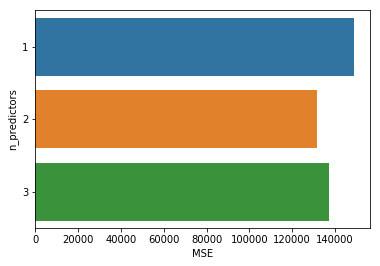

In [310]:
# Plot the error metric
sns.barplot(y='n_predictors', x='MSE', data=best, orient='h')

In [311]:
# Forward selection:
# There are 1 + p(1 + p) / 2 possible models in this space 

def fwd_selection(target_column, data):
    predictors = data.drop('Salary', axis=1).columns
    formulae_s1 = [(p, 'Salary ~ {}'.format(p)) for p in predictors]
    models_s1 = [(p, smf.ols(formula=f, data=data).fit()) for p, f in formulae_s1]
    predictor_s1, model_s1 = sorted(models_s1, key=lambda tup: tup[1].rsquared, reverse=True)[0]
    predictors = predictors.drop(predictor_s1)
    formula = 'Salary ~ {}'.format(predictor_s1)
    step_models = [model_s1]
    while len(predictors) > 0:
        models = []
        for p in predictors:
            f = formula + ' + ' + p
            m = smf.ols(formula=f, data=data).fit()
            models.append((p, m))
                    
        predictor, model = sorted(models, key=lambda tup: tup[1].rsquared, reverse=True)[0]
        step_models.append(model)
        formula = formula + ' + ' + predictor
        predictors = predictors.drop(predictor)
        
    return pd.DataFrame({'model': step_models, 'n_predictors' : range(1, 20)})

In [312]:
# Select between models with different numbers of predictors using adjusted training metrics
best = fwd_selection('Salary', hitters_dat)
best['adj_R_sq'] = best['model'].map(lambda m: m.rsquared_adj)
best['bic'] = best['model'].map(lambda m: m.bic)
best['aic'] = best['model'].map(lambda m: m.aic)

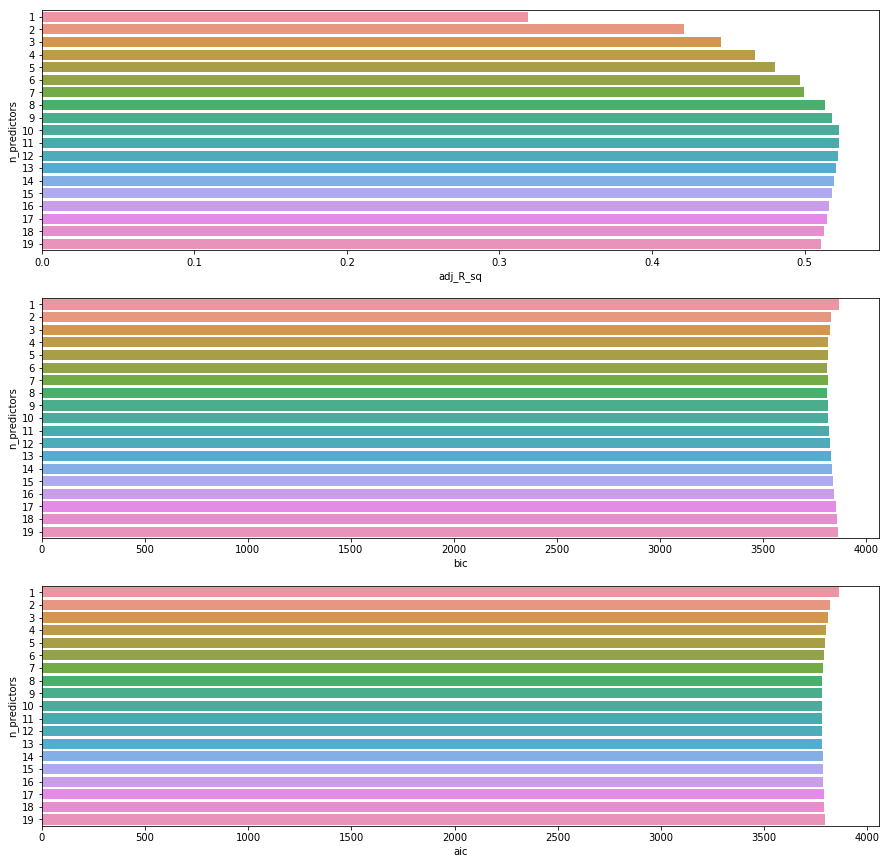

In [313]:
# Plot the error metrics
_, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15,15))
sns.barplot(y='n_predictors', x='adj_R_sq', data=best, ax=ax1, orient='h')
sns.barplot(y='n_predictors', x='bic', data=best, ax=ax2, orient='h')
sns.barplot(y='n_predictors', x='aic', data=best, ax=ax3, orient='h')

In [314]:
# Select between models with different numbers of predictors using the validation set approach
train, test = model_selection.train_test_split(hitters_dat, test_size=0.2)
best = fwd_selection('Salary', train)
best['MSE'] = best['model'].map(lambda m: metrics.mean_squared_error(test['Salary'], m.predict(test)))
best

,model,n_predictors,MSE
0,<statsmodels.regression.linear_model.Regressio...,1,135508.216515
1,<statsmodels.regression.linear_model.Regressio...,2,147033.581930
2,<statsmodels.regression.linear_model.Regressio...,3,147669.747336
3,<statsmodels.regression.linear_model.Regressio...,4,128926.294401
4,<statsmodels.regression.linear_model.Regressio...,5,127644.577719
5,<statsmodels.regression.linear_model.Regressio...,6,125550.266428
6,<statsmodels.regression.linear_model.Regressio...,7,121290.957269
7,<statsmodels.regression.linear_model.Regressio...,8,116963.477452
8,<statsmodels.regression.linear_model.Regressio...,9,120501.056237
9,<statsmodels.regression.linear_model.Regressio...,10,115206.332819


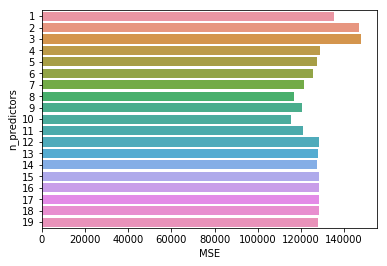

In [315]:
# Plot the error metric
sns.barplot(y='n_predictors', x='MSE', data=best, orient='h')

In [316]:
# Select between models with different numbers of predictors using cross validation
results = pd.DataFrame()
for train_idx, test_idx in model_selection.KFold(n_splits=10).split(hitters_dat):
    train = hitters_dat.iloc[train_idx]
    test = hitters_dat.iloc[test_idx]
    best = fwd_selection('Salary', train)
    mse = best['model'].map(lambda m: metrics.mean_squared_error(test['Salary'], m.predict(test)))
    results = results.append(mse, ignore_index=True)
    
best['MSE'] = results.mean()
best

,model,n_predictors,MSE
0,<statsmodels.regression.linear_model.Regressio...,1,149077.418140
1,<statsmodels.regression.linear_model.Regressio...,2,134035.444866
2,<statsmodels.regression.linear_model.Regressio...,3,130954.147117
3,<statsmodels.regression.linear_model.Regressio...,4,123682.462505
4,<statsmodels.regression.linear_model.Regressio...,5,119248.631710
5,<statsmodels.regression.linear_model.Regressio...,6,113154.213964
6,<statsmodels.regression.linear_model.Regressio...,7,115580.660634
7,<statsmodels.regression.linear_model.Regressio...,8,111934.205427
8,<statsmodels.regression.linear_model.Regressio...,9,112854.617360
9,<statsmodels.regression.linear_model.Regressio...,10,114497.887408


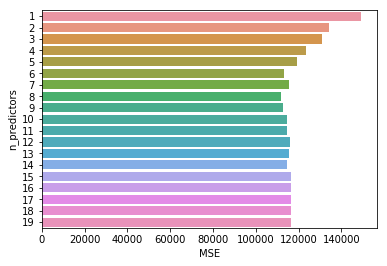

In [317]:
# Plot the error metric
sns.barplot(y='n_predictors', x='MSE', data=best, orient='h')

In [334]:
# Backward selection
# There are 1 + p(1 + p) / 2 possible models in this space 

def bwd_selection(target_column, data):
    predictors = data.drop('Salary', axis=1).columns
    formula_s1 = 'Salary ~ ' + ' + '.join(predictors)
    model_s1 = smf.ols(formula=formula_s1, data=data).fit()
    step_models = [model_s1]
    while len(predictors) > 1:
        models = []
        for p in predictors:
            f = 'Salary ~ ' + ' + '.join(predictors.drop(p))
            m = smf.ols(formula=f, data=data).fit()
            models.append((p, m))
        p, m = sorted(models, key=lambda tup: tup[1].rsquared, reverse=True)[0]
        step_models.append(m)
        predictors = predictors.drop(p)
    return pd.DataFrame({'model': step_models, 'n_predictors' : range(1, 20)[::-1]})

In [331]:
# Select between models with different numbers of predictors using adjusted training metrics
best = bwd_selection('Salary', hitters_dat)
best['adj_R_sq'] = best['model'].map(lambda m: m.rsquared_adj)
best['bic'] = best['model'].map(lambda m: m.bic)
best['aic'] = best['model'].map(lambda m: m.aic)

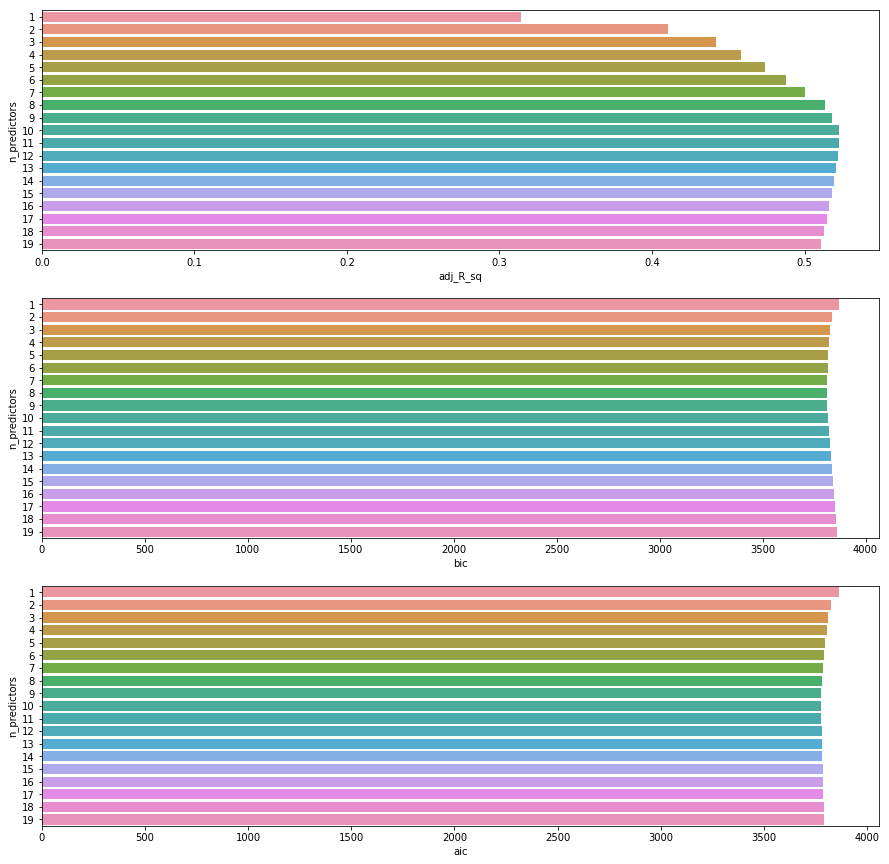

In [333]:
# Plot the error metrics
_, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15,15))
sns.barplot(y='n_predictors', x='adj_R_sq', data=best, ax=ax1, orient='h')
sns.barplot(y='n_predictors', x='bic', data=best, ax=ax2, orient='h')
sns.barplot(y='n_predictors', x='aic', data=best, ax=ax3, orient='h')

In [336]:
# Select between models with different numbers of predictors using the validation set approach
train, test = model_selection.train_test_split(hitters_dat, test_size=0.2)
best = bwd_selection('Salary', train)
best['MSE'] = best['model'].map(lambda m: metrics.mean_squared_error(test['Salary'], m.predict(test)))
best

,model,n_predictors,MSE
0,<statsmodels.regression.linear_model.Regressio...,19,133352.083840
1,<statsmodels.regression.linear_model.Regressio...,18,133284.236773
2,<statsmodels.regression.linear_model.Regressio...,17,133233.527027
3,<statsmodels.regression.linear_model.Regressio...,16,133792.636968
4,<statsmodels.regression.linear_model.Regressio...,15,133156.193247
5,<statsmodels.regression.linear_model.Regressio...,14,135624.311929
6,<statsmodels.regression.linear_model.Regressio...,13,135391.355291
7,<statsmodels.regression.linear_model.Regressio...,12,135395.399373
8,<statsmodels.regression.linear_model.Regressio...,11,133589.596734
9,<statsmodels.regression.linear_model.Regressio...,10,132451.355454


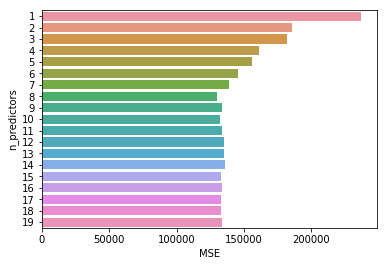

In [338]:
# Plot the error metric
sns.barplot(y='n_predictors', x='MSE', data=best, orient='h')

In [339]:
# Select between models with different numbers of predictors using cross validation
results = pd.DataFrame()
for train_idx, test_idx in model_selection.KFold(n_splits=10).split(hitters_dat):
    train = hitters_dat.iloc[train_idx]
    test = hitters_dat.iloc[test_idx]
    best = bwd_selection('Salary', train)
    mse = best['model'].map(lambda m: metrics.mean_squared_error(test['Salary'], m.predict(test)))
    results = results.append(mse, ignore_index=True)
    
best['MSE'] = results.mean()
best

,model,n_predictors,MSE
0,<statsmodels.regression.linear_model.Regressio...,19,116599.013674
1,<statsmodels.regression.linear_model.Regressio...,18,116263.927026
2,<statsmodels.regression.linear_model.Regressio...,17,115939.235073
3,<statsmodels.regression.linear_model.Regressio...,16,115616.664737
4,<statsmodels.regression.linear_model.Regressio...,15,115373.619649
5,<statsmodels.regression.linear_model.Regressio...,14,114599.797519
6,<statsmodels.regression.linear_model.Regressio...,13,115082.285922
7,<statsmodels.regression.linear_model.Regressio...,12,112655.258048
8,<statsmodels.regression.linear_model.Regressio...,11,110741.661641
9,<statsmodels.regression.linear_model.Regressio...,10,110090.954229


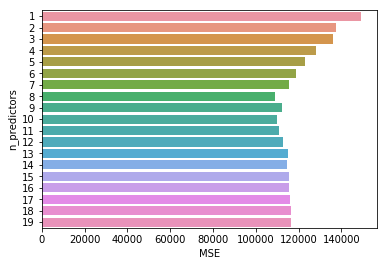

In [340]:
# Plot the error metric
sns.barplot(y='n_predictors', x='MSE', data=best, orient='h')

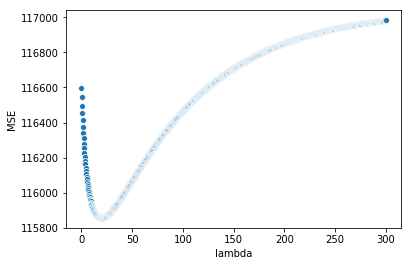

In [382]:
# Ridge Regression - Cross-Validation with test MSE

results = pd.DataFrame()
alpha_range = np.linspace(10**-3, 3 * (10**2), num=1000)
for train_idx, test_idx in model_selection.KFold(n_splits=10).split(hitters_dat):
    train, test = hitters_dat.iloc[train_idx], hitters_dat.iloc[test_idx]
    errors = []
    for alpha in alpha_range:
        reg = linear_model.Ridge(alpha=alpha)
        reg.fit(train.drop('Salary', axis=1), train['Salary'])
        error = metrics.mean_squared_error(test['Salary'], reg.predict(test.drop('Salary', axis=1)))
        errors.append(error)
    results = pd.concat([results, pd.DataFrame(errors, index=alpha_range).T], axis=0, ignore_index=True)

df = pd.DataFrame({'lambda' : alpha_range, 'MSE' : results.mean()})
sns.scatterplot(x='lambda', y='MSE', data=df)

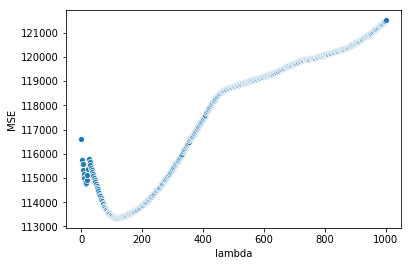

In [384]:
# LASSO Regression - Cross-Validation with test MSE

results = pd.DataFrame()
alpha_range = np.linspace(10**-2, 10**3, num=500)
for train_idx, test_idx in model_selection.KFold(n_splits=10).split(hitters_dat):
    train, test = hitters_dat.iloc[train_idx], hitters_dat.iloc[test_idx]
    errors = []
    for alpha in alpha_range:
        reg = linear_model.Lasso(alpha=alpha, max_iter=10000)
        reg.fit(train.drop('Salary', axis=1), train['Salary'])
        error = metrics.mean_squared_error(test['Salary'], reg.predict(test.drop('Salary', axis=1)))
        errors.append(error)
    results = pd.concat([results, pd.DataFrame(errors, index=alpha_range).T], axis=0, ignore_index=True)
    

df = pd.DataFrame({'lambda' : alpha_range, 'MSE' : results.mean()})
sns.scatterplot(x='lambda', y='MSE', data=df)

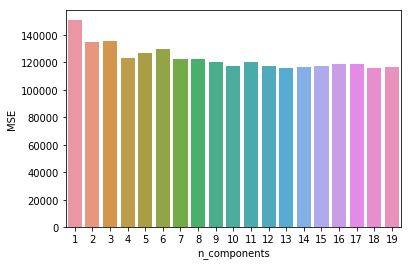

In [387]:
# PCR Regression - Cross-Validation with test MSE

results = pd.DataFrame()
predictors = hitters_dat.drop('Salary', axis=1).columns
c_range = range(1, len(predictors) + 1)
for train_idx, test_idx in model_selection.KFold(n_splits=10).split(hitters_dat):
    train, test = hitters_dat.iloc[train_idx], hitters_dat.iloc[test_idx]
    errors = []
    for c in c_range:
        pca = decomposition.PCA(n_components=c)
        X = pca.fit_transform(train.drop('Salary', axis=1))
        reg = linear_model.LinearRegression()
        reg.fit(X, train['Salary'])
        
        test_X = pca.transform(test.drop('Salary', axis=1))
        error = metrics.mean_squared_error(test['Salary'], reg.predict(test_X))
        #error = metrics.mean_squared_error(test['Salary'], reg.predict(test_X))
        errors.append(error)
    results = pd.concat([results, pd.DataFrame(errors, index=c_range).T], axis=0, ignore_index=True)

df = pd.DataFrame({'n_components' : c_range, 'MSE' : results.mean()})
sns.barplot(x='n_components', y='MSE', data=df)

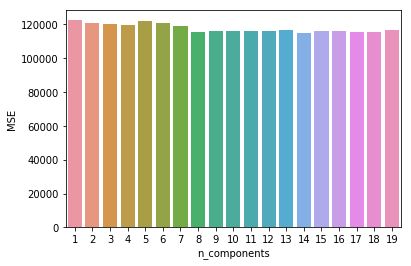

In [388]:
# PLS Regression - Cross-Validation with test MSE

results = pd.DataFrame()
predictors = hitters_dat.drop('Salary', axis=1).columns
c_range = range(1, len(predictors) + 1)
for train_idx, test_idx in model_selection.KFold(n_splits=10).split(hitters_dat):
    train, test = hitters_dat.iloc[train_idx], hitters_dat.iloc[test_idx]
    errors = []
    for c in c_range:
        reg = cross_decomposition.PLSRegression(n_components=c)
        reg.fit(train.drop('Salary', axis=1), train['Salary'])
        error = metrics.mean_squared_error(test['Salary'], reg.predict(test.drop('Salary', axis=1)))
        errors.append(error)
    results = pd.concat([results, pd.DataFrame(errors, index=c_range).T], axis=0, ignore_index=True)

df = pd.DataFrame({'n_components' : c_range, 'MSE' : results.mean()})
sns.barplot(x='n_components', y='MSE', data=df)